In [196]:
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve
import root_pandas as rp
import numpy as np
import ROOT as root
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Concatenate, concatenate
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization, Input
from keras import regularizers

## Step 1: read the root file and save it to Nx3x3x5 array

In [105]:
def get_array_from_rootfile(inputFileName, treename):
    inputFile = root.TFile(inputFileName)
    variables_array = ["STr2_ehitG_rec", "STr2_overlapG_rec", "STr2_gapG_rec"]
    variables_1d = ["STr2_enG_rec", "STr2_enG_true", "STr2_iEtaiX", "STr2_iPhiiY"]
    tree = inputFile.Get(treename)
    NEntries = tree.GetEntries()
    print("Reading tree "+treename+", NEntries = "+str(NEntries))
    dfp = rp.read_root(inputFileName, key=treename, columns=variables_array+variables_1d, flatten=variables_array)
    df = dfp.reindex(columns=variables_array+variables_1d)
    arr_df = df.values
    X = np.zeros((NEntries, 3, 3, 5))
    Y = np.zeros(NEntries)
    Y_raw = np.zeros(NEntries)
    for idx in range(NEntries):
        temp = np.array([
                [
                  [arr_df[idx*9+8][0], arr_df[idx*9+7][0], arr_df[idx*9+6][0]],
                  [arr_df[idx*9+5][0], arr_df[idx*9+4][0], arr_df[idx*9+3][0]],
                  [arr_df[idx*9+2][0], arr_df[idx*9+1][0], arr_df[idx*9+0][0]]
                ],

                [
                  [arr_df[idx*9+8][1], arr_df[idx*9+7][1], arr_df[idx*9+6][1]],
                  [arr_df[idx*9+5][1], arr_df[idx*9+4][1], arr_df[idx*9+3][1]],
                  [arr_df[idx*9+2][1], arr_df[idx*9+1][1], arr_df[idx*9+0][1]]
                ],
                [
                  [arr_df[idx*9+8][2], arr_df[idx*9+7][2], arr_df[idx*9+6][2]],
                  [arr_df[idx*9+5][2], arr_df[idx*9+4][2], arr_df[idx*9+3][2]],
                  [arr_df[idx*9+2][2], arr_df[idx*9+1][2], arr_df[idx*9+0][2]]
                ],
                [
                  [arr_df[idx*9+8][5]-1, arr_df[idx*9+7][5], arr_df[idx*9+6][5]+1],
                  [arr_df[idx*9+5][5]-1, arr_df[idx*9+4][5], arr_df[idx*9+3][5]+1],
                  [arr_df[idx*9+2][5]-1, arr_df[idx*9+1][5], arr_df[idx*9+0][5]+1]
                ],
                [
                  [arr_df[idx*9+8][6]+1, arr_df[idx*9+7][6]+1, arr_df[idx*9+6][6]+1],
                  [arr_df[idx*9+5][6], arr_df[idx*9+4][6], arr_df[idx*9+3][6]],
                  [arr_df[idx*9+2][6]-1, arr_df[idx*9+1][6]-1, arr_df[idx*9+0][6]-1]
                ]
              ])
        X[idx] = np.copy(np.rollaxis(temp, 0, 3))
        Y[idx] = arr_df[idx*9][4]
        Y_raw[idx] = arr_df[idx*9][3]
        
    return X, Y, Y_raw

In [106]:
X_train_gamma1, Y_train_gamma1, Y_raw_train_gamma1= get_array_from_rootfile("data/photonNtuple_EB.root", "Tree_Optim_train_gamma1")

Reading tree Tree_Optim_train_gamma1, NEntries = 523126


In [107]:
X_test_gamma1, Y_test_gamma1, Y_raw_test_gamma1 = get_array_from_rootfile("data/photonNtuple_EB.root", "Tree_Optim_test_gamma1")

Reading tree Tree_Optim_test_gamma1, NEntries = 92069


In [57]:
for idx in range(len(X_train_gamma1[0,0,0,:])):
    print(X_train_gamma1[0,:,:,idx])

[[0.09377262 0.36675191 0.        ]
 [0.82470185 6.8442812  0.27380589]
 [0.14313883 0.10411293 0.        ]]
[[ 0.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  0.  0.]]
[[7.0999999  6.9000001  6.9000001 ]
 [7.0999999  6.9000001  6.9000001 ]
 [1.60000002 1.39999998 1.39999998]]
[[-63. -62. -61.]
 [-63. -62. -61.]
 [-63. -62. -61.]]
[[341. 341. 341.]
 [340. 340. 340.]
 [339. 339. 339.]]


## Step2: basic visualization to see the data feature

In [66]:
def plot_3x3map(hitmap, iEtaiX, iPhiiY, ETrue):
    os.system('mkdir -p plots')
    plt.clf()
    ax = plt.subplot(1,1,1)
    plt.imshow(hitmap, cmap=plt.cm.coolwarm, alpha=.9)#, extent=extent)
    plt.xticks([0,1,2], fontsize=16)
    plt.yticks([0,1,2], fontsize=16)
    ax.set_xticklabels(["%.0f"%(iEtaiX-1),"%.0f"%(iEtaiX),"%.0f"%(iEtaiX+1)])
    ax.set_yticklabels(["%.0f"%(iPhiiY+1),"%.0f"%(iPhiiY),"%.0f"%(iPhiiY-1)])
    for i in range(3):
        for j in range(3):
            plt.text(i, j, "%.2f"%hitmap[j][i], ha="center", va="center", color="w", fontsize=16)
    EReco = np.sum(hitmap)
    plt.title("$E_{reco}$/$E_{true}$ = %.2f/%.2f = %.2f"%(EReco, ETrue, EReco/ETrue))
    plt.xlabel('i$\eta$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=-17)
    plt.ylabel('i$\phi$',horizontalalignment='right', y=1.0, fontsize=14, labelpad=-17)
    plt.savefig("plots/hitmap_seed_iEta%.0f_iPhi%.0f.pdf"%(iEtaiX, iPhiiY))
    plt.savefig("plots/hitmap_seed_iEta%.0f_iPhi%.0f.png"%(iEtaiX, iPhiiY))
    #plt.show()
    
    if EReco > 0:
        plt.clf()
        ax = plt.subplot(1,1,1)
        plt.imshow(hitmap/EReco, cmap=plt.cm.coolwarm, alpha=.9)#, extent=extent)
        plt.xticks([0,1,2], fontsize=16)
        plt.yticks([0,1,2], fontsize=16)
        ax.set_xticklabels(["%.0f"%(iEtaiX-1),"%.0f"%(iEtaiX),"%.0f"%(iEtaiX+1)])
        ax.set_yticklabels(["%.0f"%(iPhiiY+1),"%.0f"%(iPhiiY),"%.0f"%(iPhiiY-1)])
        for i in range(3):
            for j in range(3):
                plt.text(i, j, "%.2f"%(hitmap[j][i]/EReco), ha="center", va="center", color="w", fontsize=16)
        plt.title("$E_{reco}$/$E_{true}$ = %.2f/%.2f = %.2f"%(EReco, ETrue, EReco/ETrue))
        plt.xlabel('i$\eta$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=-17)
        plt.ylabel('i$\phi$',horizontalalignment='right', y=1.0, fontsize=14, labelpad=-17)
        plt.savefig("plots/hitmap_ratio_seed_iEta%.0f_iPhi%.0f.pdf"%(iEtaiX, iPhiiY))
        plt.savefig("plots/hitmap_ratio_seed_iEta%.0f_iPhi%.0f.png"%(iEtaiX, iPhiiY))
        #plt.show()
def plot_3x3map_iEta_constant(hitmap, iEtaiX, ETrue):
    os.system('mkdir -p plots')
    plt.clf()
    ax = plt.subplot(1,1,1)
    plt.imshow(hitmap, cmap=plt.cm.coolwarm, alpha=.9)#, extent=extent)
    plt.xticks([0,1,2], fontsize=16)
    plt.yticks([0,1,2], fontsize=16)
    ax.set_xticklabels(["%.0f"%(iEtaiX-1),"%.0f"%(iEtaiX),"%.0f"%(iEtaiX+1)])
    ax.set_yticklabels(["Y+1","Y","Y-1"])
    for i in range(3):
        for j in range(3):
            plt.text(i, j, "%.2f"%hitmap[j][i], ha="center", va="center", color="w", fontsize=16)
    EReco = np.sum(hitmap)
    plt.title("$E_{reco}$/$E_{true}$ = %.2f/%.2f = %.2f"%(EReco, ETrue, EReco/ETrue))
    plt.xlabel('i$\eta$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=-17)
    plt.ylabel('i$\phi$',horizontalalignment='right', y=1.0, fontsize=14, labelpad=-17)
    plt.savefig("plots/hitmap_constant_seed_iEta%.0f.pdf"%iEtaiX)
    plt.savefig("plots/hitmap_constant_seed_iEta%.0f.png"%iEtaiX)
    #plt.show()
    
    if EReco > 0:
        plt.clf()
        ax = plt.subplot(1,1,1)
        plt.imshow(hitmap/EReco, cmap=plt.cm.coolwarm, alpha=.9)#, extent=extent)
        plt.xticks([0,1,2], fontsize=16)
        plt.yticks([0,1,2], fontsize=16)
        ax.set_xticklabels(["%.0f"%(iEtaiX-1),"%.0f"%(iEtaiX),"%.0f"%(iEtaiX+1)])
        ax.set_yticklabels(["Y+1","Y","Y-1"])
        for i in range(3):
            for j in range(3):
                plt.text(i, j, "%.2f"%(hitmap[j][i]/EReco), ha="center", va="center", color="w", fontsize=16)
        plt.title("$E_{reco}$/$E_{true}$ = %.2f/%.2f = %.2f"%(EReco, ETrue, EReco/ETrue))
        plt.xlabel('i$\eta$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=-17)
        plt.ylabel('i$\phi$',horizontalalignment='right', y=1.0, fontsize=14, labelpad=-17)
        plt.savefig("plots/hitmap_ratio_constant_seed_iEta%.0f.pdf"%iEtaiX)
        plt.savefig("plots/hitmap_ratio_constant_seed_iEta%.0f.png"%iEtaiX)
        #plt.show() 
def plot_3x3map_iPhi_constant(hitmap, iPhiiY, ETrue):
    os.system('mkdir -p plots')
    plt.clf()
    ax = plt.subplot(1,1,1)
    plt.imshow(hitmap, cmap=plt.cm.coolwarm, alpha=.9)#, extent=extent)
    plt.xticks([0,1,2], fontsize=16)
    plt.yticks([0,1,2], fontsize=16)
    ax.set_yticklabels(["%.0f"%(iPhiiY+1),"%.0f"%(iPhiiY),"%.0f"%(iPhiiY-1)])
    ax.set_xticklabels(["X+1","X","X-1"])
    for i in range(3):
        for j in range(3):
            plt.text(i, j, "%.2f"%hitmap[j][i], ha="center", va="center", color="w", fontsize=16)
    EReco = np.sum(hitmap)
    plt.title("$E_{reco}$/$E_{true}$ = %.2f/%.2f = %.2f"%(EReco, ETrue, EReco/ETrue))
    plt.xlabel('i$\eta$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=-17)
    plt.ylabel('i$\phi$',horizontalalignment='right', y=1.0, fontsize=14, labelpad=-17)
    plt.savefig("plots/hitmap_constant_seed_iPhi%.0f.pdf"%iPhiiY)
    plt.savefig("plots/hitmap_constant_seed_iPhi%.0f.png"%iPhiiY)
    #plt.show()
    
    if EReco > 0:
        plt.clf()
        ax = plt.subplot(1,1,1)
        plt.imshow(hitmap/EReco, cmap=plt.cm.coolwarm, alpha=.9)#, extent=extent)
        plt.xticks([0,1,2], fontsize=16)
        plt.yticks([0,1,2], fontsize=16)
        ax.set_yticklabels(["%.0f"%(iPhiiY+1),"%.0f"%(iPhiiY),"%.0f"%(iPhiiY-1)])
        ax.set_xticklabels(["X+1","X","X-1"])
        for i in range(3):
            for j in range(3):
                plt.text(i, j, "%.2f"%(hitmap[j][i]/EReco), ha="center", va="center", color="w", fontsize=16)
        plt.title("$E_{reco}$/$E_{true}$ = %.2f/%.2f = %.2f"%(EReco, ETrue, EReco/ETrue))
        plt.xlabel('i$\eta$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=-17)
        plt.ylabel('i$\phi$',horizontalalignment='right', y=1.0, fontsize=14, labelpad=-17)
        plt.savefig("plots/hitmap_ratio_constant_seed_iPhi%.0f.pdf"%iPhiiY)
        plt.savefig("plots/hitmap_ratio_constant_seed_iPhi%.0f.png"%iPhiiY)
        #plt.show() 
        
def plot_3x3gapmap(gapmap, iEtaiX, iPhiiY):
    os.system('mkdir -p plots')
    plt.clf()
    ax = plt.subplot(1,1,1)
    plt.imshow(gapmap, cmap=plt.cm.coolwarm, alpha=.9)#, extent=extent)
    plt.xticks([0,1,2], fontsize=16)
    plt.yticks([0,1,2], fontsize=16)
    ax.set_xticklabels(["%.0f"%(iEtaiX-1),"%.0f"%(iEtaiX),"%.0f"%(iEtaiX+1)])
    ax.set_yticklabels(["%.0f"%(iPhiiY+1),"%.0f"%(iPhiiY),"%.0f"%(iPhiiY-1)])
    for i in range(3):
        for j in range(3):
            plt.text(i, j, "%.2f"%gapmap[j][i], ha="center", va="center", color="w", fontsize=16)
    plt.title("Gap Size [mm]")
    plt.xlabel('i$\eta$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=-17)
    plt.ylabel('i$\phi$',horizontalalignment='right', y=1.0, fontsize=14, labelpad=-17)
    plt.savefig("plots/gapmap_seed_iEta%.0f_iPhi%.0f.pdf"%(iEtaiX, iPhiiY))
    plt.savefig("plots/gapmap_seed_iEta%.0f_iPhi%.0f.png"%(iEtaiX, iPhiiY))
    #plt.show()

def average_map(iEta, iPhi, hitmap_all, ETrue_all, iEtaiX_all, iPhiiY_all):
    hitmap = np.zeros((3,3))
    ETrue = 0.0
    if iEta < -84.5 or iEta > 84.5:
        return hitmap, ETrue
    if iPhi < 1.5 or iPhi > 359.5:
        return hitmap, ETrue
    num_total = 0
    
    for idx in range(len(hitmap_all)):
        if iEtaiX_all[idx][1][1] == iEta and iPhiiY_all[idx][1][1] == iPhi:
            #print(hitmap_all[idx])
            num_total += 1
            hitmap = np.copy(hitmap+hitmap_all[idx])
            ETrue += ETrue_all[idx]
    hitmap = hitmap/num_total
    ETrue = ETrue/num_total
    return hitmap, ETrue
def average_map_iEta_constant(iEta, hitmap_all, ETrue_all, iEtaiX_all):
    hitmap = np.zeros((3,3))
    ETrue = 0.0
    if iEta < -84.5 or iEta > 84.5:
        return hitmap, ETrue
    num_total = 0
    for idx in range(len(hitmap_all)):
        if iEtaiX_all[idx][1][1] == iEta:
            num_total += 1
            hitmap = np.copy(hitmap+hitmap_all[idx])
            ETrue += ETrue_all[idx]
    hitmap = hitmap/num_total
    ETrue = ETrue/num_total
    return hitmap, ETrue

def average_map_iPhi_constant(iPhi, hitmap_all, ETrue_all, iPhiiY_all):
    hitmap = np.zeros((3,3))
    ETrue = 0.0
    if iPhi < 1.5 or iPhi > 359.5:
        return hitmap, ETrue
    num_total = 0
    
    for idx in range(len(hitmap_all)):
        if iPhiiY_all[idx][1][1] == iPhi:
            num_total += 1
            hitmap = np.copy(hitmap+hitmap_all[idx])
            ETrue += ETrue_all[idx]
    hitmap = hitmap/num_total
    ETrue = ETrue/num_total
    return hitmap, ETrue

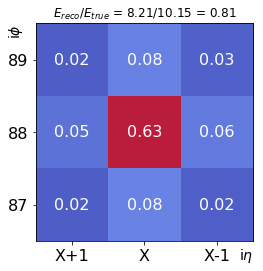

In [72]:
## plot hitmap for seed crystals in iEta iPhi of interest
iEtaiPhi_interests = [[25,20], [24,20], [24,19], [23,18], 
                      [23,38], [23,58], [23,78],[23,98], 
                      [43,18], [63,18], [83,18]]
index_interests = np.zeros(len(iEtaiPhi_interests), dtype=np.int32) - 999
for idx1 in range(len(X_train_gamma1)):
    allFound = True
    for idx2 in range(len(index_interests)):
        if X_train_gamma1[idx1,:,:,3][1][1] == iEtaiPhi_interests[idx2][0] and X_train_gamma1[idx1,:,:,4][1][1] == iEtaiPhi_interests[idx2][1]:
            index_interests[idx2] = idx1
        if index_interests[idx2] < 0:
            allFound = False
    if allFound:
        break
for idx in range(len(iEtaiPhi_interests)):
    plot_3x3gapmap(X_train_gamma1[index_interests[idx],:,:,2],X_train_gamma1[index_interests[idx],:,:,3][1][1], X_train_gamma1[index_interests[idx],:,:,4][1][1])
    hitmap_this, ETrue_this = average_map(iEtaiPhi_interests[idx][0],iEtaiPhi_interests[idx][1],X_train_gamma1[:,:,:,0], Y_train_gamma1, X_train_gamma1[:,:,:,3], X_train_gamma1[:,:,:,4])  
    plot_3x3map(hitmap_this, iEtaiPhi_interests[idx][0],iEtaiPhi_interests[idx][1], ETrue_this)
    
## plot hitmap for seed crystals at constant iEta or iPhi
iEta_interests = [25, 24, 23, 43, 63, 83]
for idx in range(len(iEta_interests)):
    hitmap_this, ETrue_this = average_map_iEta_constant(iEta_interests[idx],X_train_gamma1[:,:,:,0], Y_train_gamma1, X_train_gamma1[:,:,:,3])  
    plot_3x3map_iEta_constant(hitmap_this, iEta_interests[idx], ETrue_this)
iPhi_interests = [20, 19, 18, 38, 58, 88]
for idx in range(len(iPhi_interests)):
    hitmap_this, ETrue_this = average_map_iPhi_constant(iPhi_interests[idx],X_train_gamma1[:,:,:,0], Y_train_gamma1, X_train_gamma1[:,:,:,4])  
    plot_3x3map_iPhi_constant(hitmap_this, iPhi_interests[idx], ETrue_this)

## Step3: build and train the Pi0Net model

In [241]:
#x_train, x_valid, y_train, y_valid = train_test_split(X_train_gamma1, Y_train_gamma1, test_size=0.2, random_state=1992)
def getPi0Net():
    input_CNN = Input(shape=(3,3,5), name='input_CNN')
    input_Dense = Input(shape=(1,), name='input_Dense')

    model1 = Conv2D(16, (2, 2), padding='valid', activation='relu')(input_CNN)
    model1_out = Flatten()(model1)

    model2 = Conv2D(16, (1, 3), padding='valid', activation='relu')(input_CNN)
    model2_out = Flatten()(model2)

    model3 = Conv2D(16, (3, 1), padding='valid', activation='relu')(input_CNN)
    model3_out = Flatten()(model3)

    model_con1 = concatenate([model1_out, model2_out, model3_out])

    model_con1 = Dense(64, activation='relu')(model_con1)
    model_con1 = Dense(32, activation='relu')(model_con1)

    model_con2 = concatenate([model_con1, input_Dense])
    model_con2 = Dense(16, activation='relu')(model_con2)
    main_output = Dense(1)(model_con2)

    model = Model(inputs=[input_CNN,input_Dense], outputs=main_output)

    model.compile(optimizer='Adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    return model

model = getPi0Net()
model.summary()
#model.fit([X_train_gamma1,Y_raw_train_gamma1], Y_train_gamma1, epochs=10, batch_size=32)
#model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_valid, y_valid))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_CNN (InputLayer)          (None, 3, 3, 5)      0                                            
__________________________________________________________________________________________________
conv2d_151 (Conv2D)             (None, 2, 2, 16)     336         input_CNN[0][0]                  
__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 3, 1, 16)     256         input_CNN[0][0]                  
__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 1, 3, 16)     256         input_CNN[0][0]                  
__________________________________________________________________________________________________
flatten_14

In [228]:
Y_predict_test_gamma1 = model.predict([X_test_gamma1, Y_raw_test_gamma1]).flatten()
print(Y_predict_test_gamma1[:10])
print(Y_raw_test_gamma1[:10])
print(Y_test_gamma1[:10])

[ 6.3883576  6.558522   9.946814   9.713714   9.97624    8.897541
  5.6263     7.442049  14.206652   6.5679035]
[ 6.58856153  1.47646618  9.93165112 10.64803696  9.55101776 11.29802322
  3.18591595  7.90251541 11.19425488  5.7607646 ]
[11.12808132  9.59782505 11.89663219  9.42013741 10.04953384  7.30640411
  3.38078475  7.36120129 12.58422375  6.35194445]


## Step 4: plot the energy response before and after correction

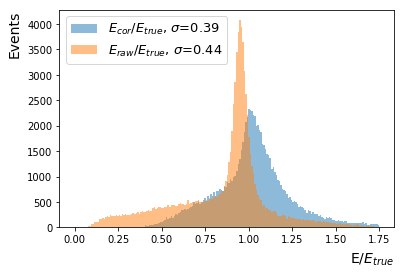

In [238]:
def plot_E_over_Etrue(Y_true, Y_raw, Y_cor, plotname):
    plt.clf()
    Y_raw_over_true = np.divide(Y_raw, Y_true)
    Y_cor_over_true = np.divide(Y_cor, Y_true)
    std_raw = np.std(Y_raw_over_true)
    std_cor = np.std(Y_cor_over_true)
    plt.hist(Y_cor_over_true, bins=200, range=(0,1.75), alpha=0.5, label='$E_{cor}$/$E_{true}$, $\sigma$=%.2f'%std_raw)
    plt.hist(Y_raw_over_true, bins=200, range=(0,1.75), alpha=0.5, label='$E_{raw}$/$E_{true}$, $\sigma$=%.2f'%std_cor)
    plt.legend(fontsize=13, loc='upper left')
    plt.xlabel('E/$E_{true}$',horizontalalignment='right', x=1.0, fontsize=14, labelpad=6)
    plt.ylabel('Events',horizontalalignment='right', y=1.0, fontsize=14, labelpad=6)
    #plt.show()
    plt.savefig('plots/'+plotname+'.pdf')
    plt.savefig('plots/'+plotname+'.png')
    
plot_E_over_Etrue(Y_test_gamma1, Y_raw_test_gamma1, Y_predict_test_gamma1, "EoverEtrue_gamma1")
